In [1]:
import pandas as pd
import numpy as np
import pickle
import argparse
import sys
import os

### Following is code from RF_deploy.py

In [2]:
def gene_checker(input_file, classifier_genes):
    '''
    Function checks the input file's genes.
    The intersection between the input file's genes and the predetermined classifier genes is taken.
    Then the function checks for genes are not present in the input file.
    For those genes, the expression vector is set to 0.
    A new dataframe is returned with the correct order of genes.

    Parameters
    ----------
    input_file; pandas df - shape should be (samples x genes)
    
    Returns
    ---------
    new_input_file; pandas df - shape (samples x genes)
    '''
    
    new_input_file = input_file.T.loc[classifier_genes].T # seleting classifier selected genes in the classifier determined order
    
    # will fill genes that do not exist in the input with zero
    # if no NAN values, none will be filled
    new_input_file = new_input_file.fillna(0) 
    
    return new_input_file

def deploy(input_file, model_path):

    expr_input = input_file
    classifier_genes = np.loadtxt('../data_test/ClassifierGenes.txt', dtype='str')
        
    print('reading input...') 
    expr_input = pd.read_csv(expr_input, sep='\t', index_col=0)

    print("before gene intersection...")
    print(expr_input.shape)
    expr_input = gene_checker(expr_input, classifier_genes) # making sure genes are correct for classifier
    print("After gene intersection...")
    print(expr_input.shape)

    print('applying model...')
    model = pickle.load(open(model_path, 'rb'))
    print(model)
    
    predictions = model.predict(expr_input)
    predict_proba = model.predict_proba(expr_input)
    
    print("saving results...")
    predictions = pd.DataFrame(np.hstack([predictions.reshape(-1,1), predict_proba]), index=expr_input.index, columns=['Ribo', 'Proba_0', 'Proba_1'])

    return predictions

## Applying balanced model on openPBTA polyA samples

In [3]:
balanced_predictions = deploy("../data/pbta-gene-expression-rsem-tpm.polya.csv", "../models/RiboVsPoly_balanced.sav")

reading input...
before gene intersection...
(58, 58347)
After gene intersection...
(58, 5000)
applying model...


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
saving results...


In [4]:
# All samples were predicted to be polyA
balanced_predictions.Ribo.value_counts()

0.0    58
Name: Ribo, dtype: int64

## Applying unbalanced model on openPBTA polyA samples

In [5]:
unbalanced_predictions = deploy("../data/pbta-gene-expression-rsem-tpm.polya.csv", "../models/RiboVsPoly_unbalanced.sav")

reading input...
before gene intersection...
(58, 58347)
After gene intersection...
(58, 5000)
applying model...
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


saving results...


In [6]:
# one sample was predicted to be ribo by the unbalanced model
unbalanced_predictions.Ribo.value_counts()

0.0    58
Name: Ribo, dtype: int64

# All polyA samples were classified correctly

Text(0.5, 1.0, 'Unbalanced Model on PolyA PBTA')

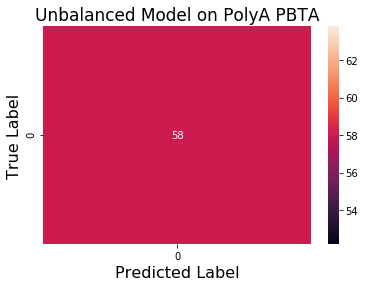

In [9]:
true_labels = 58*[0]
pred_labels = unbalanced_predictions.Ribo.values

from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(true_labels, pred_labels)
ax = sns.heatmap(mat, annot=True)
ax.set_ylabel("True Label", fontsize=16)
ax.set_xlabel("Predicted Label", fontsize=16)
ax.set_title("Unbalanced Model on PolyA PBTA", fontsize=17)